# Elastic deformation (Dead Sea shape)

## Tools

*Modules*

In [1]:
import numpy as np
from scipy.special import ellipe, ellipk
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pandas as pd

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.cm as cmx
import matplotlib.ticker as ti
from matplotlib import patheffects
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmcrameri.cm as cmc

import cartopy.crs as ccrs
import cartopy.feature as cf
import pygmt
from pygmt.datasets import load_earth_relief
from fontTools.ttLib import TTFont
from matplotlib.font_manager import fontManager, FontProperties

In [2]:
plt.style.use('myfig.mplstyle')

*Paths*

In [3]:
# paths
wkdir = "/Users/emile/Documents/Etude/2024_2025_M2/tutored_project"
datadir = "{:}/data".format(wkdir)
plotdir = "{:}/figures".format(wkdir)

*Dead Sea shapefile*

In [4]:
crs_geo = 'EPSG:4326'
crs_utm = 'EPSG:32636'

In [5]:
dead_sea_shp_geo = gpd.read_file("{:}/Dead_sea_shapefile/dead_sea.shp".format(datadir))
dead_sea_shp_utm = dead_sea_shp_geo.to_crs(crs_utm)

In [6]:
x_dead_sea, y_dead_sea = dead_sea_shp_utm.geometry[0].exterior.xy
x_dead_sea = np.array(x_dead_sea)
y_dead_sea = np.array(y_dead_sea)

*Import mesh*

In [7]:
res = 8

mesh_disk_geo = pd.read_csv("{:}/Dead_Sea_mesh/mesh_geo_res{:}.txt".format(datadir, res), sep='\t')
mesh_disk_utm = pd.read_csv("{:}/Dead_Sea_mesh/mesh_utm_res{:}.txt".format(datadir, res), sep='\t')

Ndisk = len(mesh_disk_geo)

*Functions*

In [8]:
def elastic_vertical_displacement(r, p, a, nu, E):
    """
    This function computes the vertical displacement of the
    surface generated by a uniform load over a circular area
    at a given distance.
    
    From:
    
    Verruijt, A. (2010). Elastodynamics of a Half Space.
    In: An Introduction to Soil Dynamics. Theory and Applications
    of Transport in Porous Media, vol 24. Springer,
    Dordrecht. https://doi.org/10.1007/978-90-481-3441-0_9
    
    Johnson, K. L. (1987). Contact mechanics. Cambridge University Press.

    Args:
        r (array of floats): distance at which the surface displacement is computed (m)
        p (float): load over the circular area (Pa)
        a (float): radius of the circular loaded area (m)
        nu (float): Poisson's ratio of the encasing rock
        E (float): Young's modulus of the encasing rock (Pa)
    """
    
    u = np.zeros_like(r)
    
    x = r**2/a**2
    u[r <= a] = - 4*p*a*(1-nu**2)/(np.pi*E)*ellipe(x[r <= a])
    u[r > a] = - 4*p*r[r > a]*(1-nu**2)/(np.pi*E)*(ellipe(1/x[r > a])-(1-1/x[r > a])*ellipk(1/x[r > a]))
    
    return u


def elastic_radial_displacement(r, p, a, nu, E):
    """
    This function computes the radial displacement of the
    surface generated by a uniform load over a circular area
    at a given distance.
    
    From:
    
    Verruijt, A. (2010). Elastodynamics of a Half Space.
    In: An Introduction to Soil Dynamics. Theory and Applications
    of Transport in Porous Media, vol 24. Springer,
    Dordrecht. https://doi.org/10.1007/978-90-481-3441-0_9
    
    Johnson, K. L. (1987). Contact mechanics. Cambridge University Press.

    Args:
        r (array of floats): distance at which the surface displacement is computed (m)
        p (float): load over the circular area (Pa)
        a (float): radius of the circular loaded area (m)
        nu (float): Poisson's ratio of the encasing rock
        E (float): Young's modulus of the encasing rock (Pa)
    """
    
    u = np.zeros_like(r)
    
    x = r**2/a**2
    u[r <= a] = - (1-2*nu)*(1+nu)/(2*E)*p*r[r <= a]
    u[r > a] = - (1-2*nu)*(1+nu)/(2*E)*p*a**2/r[r > a]
    
    return u


def found_font_with_unicode_char(list_unichars):
    
    def char_in_font(unicode_char, font):
        if font.endswith('.ttc'):
            fontNo = 0
        else:
            fontNo = -1
        font = TTFont(font, fontNumber=fontNo)
        for cmap in font['cmap'].tables: 
            if cmap.isUnicode():
                for i in unicode_char:
                    if ord(i) not in cmap.cmap:
                        return False
        return True

    font_list = [(f.fname, f.name) for f in fontManager.ttflist]
    for font in font_list:
        if char_in_font(list_unichars, font[0]):
            return FontProperties(fname=font[0])
    
    return None


def draw_scalebar(ax, length, location=(.9, .9), linewidth=3, units='km', m_per_unit=1000):    
    """
    http://stackoverflow.com/a/35705477/1072212
    ax is the axes to draw the scalebar on.
    proj is the projection the axes are in
    location is center of the scalebar in axis coordinates ie. 0.5 is the middle of the plot
    length is the length of the scalebar in km.
    linewidth is the thickness of the scalebar.
    units is the name of the unit
    m_per_unit is the number of meters in a unit
    """
    
    def utm_from_lon(lon):
        """
        utm_from_lon - UTM zone for a longitude
        Not right for some polar regions (Norway, Svalbard, Antartica)
        :param float lon: longitude
        :return: UTM zone number
        :rtype: int
        """
        return int(np.floor((lon+180)/6)+1)
    
    proj = ax.projection
    # find lat/lon center to find best UTM zone
    x0, x1, y0, y1 = ax.get_extent(proj.as_geodetic())
    # Projection in metres
    utm = ccrs.UTM(utm_from_lon((x0+x1)/2))
    # Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(utm)
    # Turn the specified scalebar location into coordinates in metres
    sbcx, sbcy = x0 + (x1 - x0) * location[0], y0 + (y1 - y0) * location[1]
    # Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbcx - length * m_per_unit/2, sbcx + length * m_per_unit/2]
    # buffer for scalebar
    buffer = [patheffects.withStroke(linewidth=5, foreground="w")]
    # Plot the scalebar with buffer
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
            linewidth=linewidth, path_effects=buffer)
    # Plot the scalebar label
    ax.text(sbcx, sbcy+(y1 - y0)*0.01, '{:} {:}'.format(length, units), transform=utm,
            ha='center', va='bottom', path_effects=buffer, zorder=2)
    return


def draw_north_arrow(ax, location=(.1, .9)):    
    """
    http://stackoverflow.com/a/35705477/1072212
    ax is the axes to draw the scalebar on.
    proj is the projection the axes are in
    location is center of the scalebar in axis coordinates ie. 0.5 is the middle of the plot
    length is the length of the scalebar in km.
    linewidth is the thickness of the scalebar.
    units is the name of the unit
    m_per_unit is the number of meters in a unit
    """
    
    def utm_from_lon(lon):
        """
        utm_from_lon - UTM zone for a longitude
        Not right for some polar regions (Norway, Svalbard, Antartica)
        :param float lon: longitude
        :return: UTM zone number
        :rtype: int
        """
        return int(np.floor((lon+180)/6)+1)
    
    proj = ax.projection
    # find lat/lon center to find best UTM zone
    x0, x1, y0, y1 = ax.get_extent(proj.as_geodetic())
    utm = ccrs.UTM(utm_from_lon((x0+x1)/2))
    x0, x1, y0, y1 = ax.get_extent(utm)
    # Turn the arow location into coordinates in metres
    sbcx = x0 + (x1 - x0) * location[0]
    sbcy = y0 + (y1 - y0) * location[1]
    # buffer and plot
    buffer = [patheffects.withStroke(linewidth=3, foreground="w")]
    ax.text(sbcx, sbcy, u'\u25B2\nN', fontproperties=found_font_with_unicode_char([u"\u25B2"]),
            transform=utm, ha='center', va='bottom', path_effects=buffer)
    return

## Surface displacements : realistic geometry

*Physical parameters*

In [9]:
# Poisson's ratio (encasing rock of the Dead Sea)
nu = .3

# Young's modulus (encasing rock of the Dead Sea)
E = 100e9 # Pa

# Gravity acceleration
g = 9.81 # m.s-2

*Load*

In [10]:
# The Dead sea has a surface of ~605 km2 (2016)
disk_radius = mesh_disk_utm.radius.values[0] # m

# We consider a 10 m decrease of the Dead Sea level (which corresponds roughly to the period 2010-2020).
# The density of the Dead Sea is ~1240 kg.m-3
# Thus we calculate the change in the load
# beware, here, the z-axis points downwards
dh_sea = - 10 # m
rho_sea = 1240 # kg.m-3

p = rho_sea * dh_sea * g

*Fine mesh*

In [11]:
x_center = 740
y_center = 3490

In [12]:
xmin, xmax = (x_center-150)*1E3, (x_center+150)*1E3
ymin, ymax = (y_center-150)*1E3, (y_center+150)*1E3

N = 1000

x = np.linspace(xmin, xmax, N)
y = np.linspace(ymin, ymax, N)
X, Y = np.meshgrid(x, y)

In [13]:
mask_dead_sea_2D = np.full((N, N), False)

for i in range(N):
    for j in range(N):
        if dead_sea_shp_utm.geometry[0].contains(Point(X[i, j], Y[i, j])):
            mask_dead_sea_2D[i, j] = True

In [14]:
Ux = np.zeros_like(X)
Uy = np.zeros_like(X)
Uz = np.zeros_like(X)

for idx, row in mesh_disk_utm.iterrows():
    
    R = np.sqrt((X - row.x)**2+(Y - row.y)**2)
    
    Uz += elastic_vertical_displacement(R, p, disk_radius, nu, E)
    
    Ur = elastic_radial_displacement(R, p, disk_radius, nu, E)
    
    Ux += (X-row.x)/np.sqrt((X-row.x)**2+(Y-row.y)**2) * Ur
    Uy += (Y-row.y)/np.sqrt((X-row.x)**2+(Y-row.y)**2) * Ur

Uhoriz = np.sqrt(Ux**2+Uy**2)
U = np.sqrt(Ux**2+Uy**2+Uz**2)

In [15]:
Ux[mask_dead_sea_2D] = np.nan
Uy[mask_dead_sea_2D] = np.nan
Uz[mask_dead_sea_2D] = np.nan

Uhoriz[mask_dead_sea_2D] = np.nan
U[mask_dead_sea_2D] = np.nan

*Profile*

In [16]:
x0, x1 = (x_center-100)*1E3, (x_center+100)*1E3
y0, y1 = y_center*1E3, y_center*1E3

N = 1000

x_profile = x0 + np.linspace(0, 1, N) * (x1-x0)
y_profile = y0 + np.linspace(0, 1, N) * (y1-y0)
dist_profile = np.sqrt((x_profile-x0)**2+(y_profile-y0)**2)

In [17]:
mask_dead_sea_profile = np.full(N, False)

for k in range(N):
   if dead_sea_shp_utm.geometry[0].contains(Point(x_profile[k], y_profile[k])):
      mask_dead_sea_profile[k] = True

In [18]:
Ux_profile = np.zeros_like(x_profile)
Uy_profile = np.zeros_like(x_profile)
Uz_profile = np.zeros_like(x_profile)

for idx, row in mesh_disk_utm.iterrows():
    
    R = np.sqrt((x_profile - row.x)**2+(y_profile - row.y)**2)
    
    Uz_profile += elastic_vertical_displacement(R, p, disk_radius, nu, E)
    
    Ur = elastic_radial_displacement(R, p, disk_radius, nu, E)
    
    Ux_profile += (x_profile-row.x)/np.sqrt((x_profile-row.x)**2+(y_profile-row.y)**2) * Ur
    Uy_profile += (y_profile-row.y)/np.sqrt((x_profile-row.x)**2+(y_profile-row.y)**2) * Ur

Uhoriz_profile = np.sqrt(Ux_profile**2+Uy_profile**2)
U_profile = np.sqrt(Ux_profile**2+Uy_profile**2+Uz_profile**2)

In [19]:
# Ux_profile[mask_dead_sea_profile] = np.nan
# Uy_profile[mask_dead_sea_profile] = np.nan
# Uz_profile[mask_dead_sea_profile] = np.nan

# Uhoriz_profile[mask_dead_sea_profile] = np.nan
# U_profile[mask_dead_sea_profile] = np.nan

*Plot*

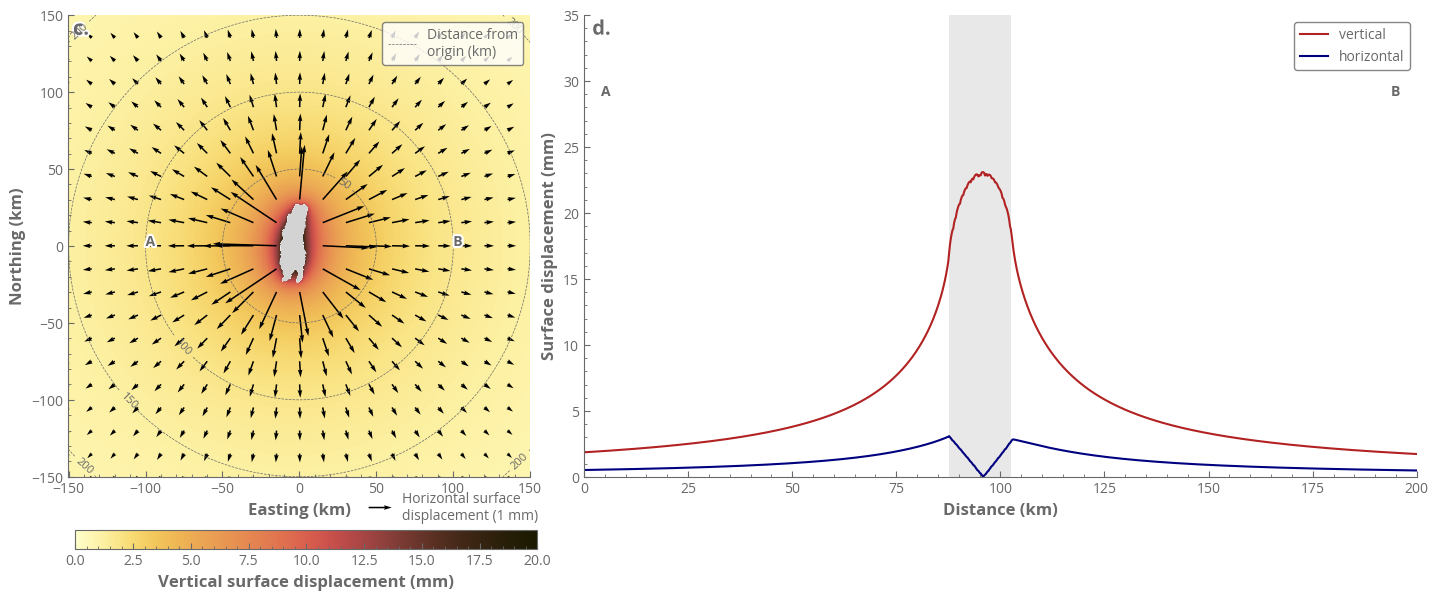

In [20]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), gridspec_kw={'width_ratios': [2, 3]})

# Map

cmap = cmc.lajolla_r
norm = mcolors.Normalize(vmin=0, vmax=20)
mappable = cmx.ScalarMappable(norm=norm, cmap=cmap)

ax[0].pcolormesh(X/1e3-x_center, Y/1e3-y_center, Uz*1e3, cmap=cmap, norm=norm)
ax[0].fill(x_dead_sea/1e3-x_center, y_dead_sea/1e3-y_center, facecolor='lightgrey')

axin = inset_axes(ax[0], width="100%", height="4%", loc="lower left",
                  bbox_to_anchor=(0, -.17, 1, 1), bbox_transform=ax[0].transAxes)
cb = fig.colorbar(mappable=mappable, cax=axin, orientation='horizontal')
cb.set_label('Vertical surface displacement (mm)')

R = np.sqrt((X - x_center*1E3)**2+(Y - y_center*1E3)**2)
CS = ax[0].contour(X/1e3-x_center, Y/1e3-y_center, R/1e3, levels=[50, 100, 150, 200, 250], colors='dimgrey', linestyles='--', linewidths=.5)
ax[0].clabel(CS, fontsize=8)
ax[0].plot([], [], color='dimgrey', linestyle='--', linewidth=.5, label='Distance from\norigin (km)')
ax[0].legend(loc='upper right')

step = 50
q = ax[0].quiver(X[::step, ::step]/1e3-x_center, Y[::step, ::step]/1e3-y_center, Ux[::step, ::step], Uy[::step, ::step],
                 units='xy', width=1)
ax[0].quiverkey(q, X=60, Y=-170, U=1e-3, coordinates='data',
                label='Horizontal surface\ndisplacement (1 mm)', labelpos='E')

ax[0].text(x0/1e3-x_center, y0/1e3-y_center, 'A', fontweight='bold', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])
ax[0].text(x1/1e3-x_center, y1/1e3-y_center, 'B', fontweight='bold', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])

ax[0].set_xlabel('Easting (km)')
ax[0].set_ylabel('Northing (km)')
ax[0].set_aspect('equal')

# Profile

ax[1].plot(dist_profile/1e3, Uz_profile*1e3, c='firebrick', label='vertical')
ax[1].plot(dist_profile/1e3, Uhoriz_profile*1e3, c='navy', label='horizontal')

ax[1].axvspan(dist_profile[mask_dead_sea_profile][0]/1e3, dist_profile[mask_dead_sea_profile][-1]/1e3,
              edgecolor='None', facecolor='lightgrey', alpha=.5, )

ax[1].set_xlabel('Distance (km)')
ax[1].set_xlim(dist_profile[0]/1e3, dist_profile[-1]/1e3)
ax[1].set_ylabel('Surface displacement (mm)')
ax[1].set_ylim(0, 35)
ax[1].legend(loc='upper right')

ax[1].text(.02, .85, 'A', transform=ax[1].transAxes, fontweight="bold", va='top', ha='left')
ax[1].text(.98, .85, 'B', transform=ax[1].transAxes, fontweight="bold", va='top', ha='right')

ax[0].text(.01, .99, 'c.', size='x-large', fontweight='bold', transform=ax[0].transAxes, va='top', ha='left', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])
ax[1].text(.01, .99, 'd.', size='x-large', fontweight='bold', transform=ax[1].transAxes, va='top', ha='left', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])

plt.subplots_adjust(wspace=.01)
fig.savefig("{:}/elastic_deformation_realistic_geometry.png".format(plotdir), dpi=300, bbox_inches='tight')
plt.show()